# Population Estimates: Samples submitted to Cloud Factory

In [1]:
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

tqdm.pandas()

In [2]:
# Import functions
%run inference-functions.ipynb import load_data, get_bounds, assign_cbgs, visualize_tile_predvOSM, assign_cbgs_by_coverage
%run ADU_permit_matching-polygon-pipeline.ipynb import load_sources

In [3]:
# Paths
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
OUTPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'outputs')
PERMIT_INPUT_FP = os.path.join(OAK_FP, 'outputs', 'Permit-Matching', 'inputs')

BUILD_FP = os.path.join(OAK_FP, 'outputs', 'cbg-inference-{}', 'inference_building_processed')
OSM_FP = os.path.join(OAK_FP, 'outputs', 'cbg-inference-2020', 'osm_building_processed')

In [4]:
# Load data
# * Residential parcels (assigned to CBGs)
sj_parcels_res = gpd.read_file(os.path.join(OUTPUT_FP, 'sj-parcels-res-cbgs'))
assert sj_parcels_res.duplicated('APN').sum() == 0

# * Census block groups
cbg_income_2016_SJ = gpd.read_file(os.path.join(OUTPUT_FP, 'Strata', 'cbg-income-strata'))

# * Permits
permits = pd.read_csv(os.path.join(OAK_FP, 'outputs/Permit-Matching/outputs/all_permits.csv'))
permits['geometry_permit'] = gpd.GeoSeries.from_wkt(permits['geometry_permit'])
permits_2015_20 = permits.loc[
    permits['issue_year'].isin([2015, 2016, 2017, 2018, 2019, 2020])].copy()

# * Parcel confidences for all parcels (based on new confidence metric)
parcel_conf_df = pd.read_csv(
    os.path.join(OUTPUT_FP, 'Confidences_construction', 'parcel-confidence.csv'), 
    dtype={'APN': str, 'GEOID': str})

# * Batch 1 Area coverage
CF_area_coverage = gpd.read_file(
    os.path.join(OUTPUT_FP, 'Outcomes', 'B1-100', 'CF_area_coverage'))

# * Batch 1 Estimates (small building constructions)
new_sbuild_2020 = pd.read_csv(
    os.path.join(OUTPUT_FP, 'Outcomes', 'B1-100', 'permit-matching-apns-CF-min11-GT1.csv'), 
    dtype={'APN': str})

In [5]:
# Add income strata information to parcel data
sj_parcels_res = pd.merge(
    sj_parcels_res, cbg_income_2016_SJ[['GEOID', 'strata_inc']], 
    how='left', validate='many_to_one')

## 1. CF Batch 1: Sample 3.5% of the parcels in each strata
Sample ~5,000 residential parcels.

In [6]:
# Sample 3.5% of parcels
percentage_of_samples = 0.035
iteration1 = pd.DataFrame()
for strata_inc in tqdm(sj_parcels_res['strata_inc'].unique()):
    parcels_to_review = sj_parcels_res.loc[sj_parcels_res['strata_inc'] == strata_inc]['APN'].unique()

    # Sample parcels
    np.random.seed(42)
    strata_inc_N = len(parcels_to_review)
    parcels_to_review = np.random.choice(
        parcels_to_review, size=int(strata_inc_N * percentage_of_samples), replace=False)

    for i, parcel_apn in enumerate(parcels_to_review):
        parcel_dict = {'APN': [parcel_apn], 'strata_inc': [strata_inc]}
        iteration1 = pd.concat([iteration1, pd.DataFrame.from_dict(parcel_dict)])

100%|██████████| 51/51 [00:02<00:00, 25.18it/s]


In [7]:
iteration1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5569 entries, 0 to 0
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   APN         5569 non-null   object
 1   strata_inc  5569 non-null   object
dtypes: object(2)
memory usage: 130.5+ KB


In [8]:
iteration1.to_csv(
    os.path.join(OUTPUT_FP, '..', 'CloudFactory', 'Iteration1', 'sampled_APNs.csv'), index=False)

In [10]:
# Generate document with parcel bins
iteration1_bins = iteration1.copy()

# Add parcel confidence data
iteration1_bins = pd.merge(
    iteration1_bins, parcel_conf_df[['APN', 'confidence', 'strata_inc']], how='left', validate='one_to_one')

# Define bin
iteration1_bins['Bin'] = iteration1_bins.apply(
    lambda row: '{}-{}'.format(row['strata_inc'], row['confidence']), axis=1)

iteration1_bins[['APN', 'Bin']].to_csv(
    os.path.join(OUTPUT_FP, '..', 'CloudFactory', 'Iteration1', 'sampled_APNs_bins.csv'), index=False)

## 2. CF Round 2: Residential parcels associated with 2015-20 AANC permits
We submit a batch of parcels that match to AANC permits issued 2015-20 to estimate the number of permits that relate to the construction of detached ADUs. 

In [21]:
# 5k AANC permits issued during 2015-20
permits_2015_20_gdf = gpd.GeoDataFrame(permits_2015_20, geometry='geometry_permit', crs='EPSG:4326')

In [22]:
# 3k AANC permits issued during 2015-20 that spatially fall within our residential boundary
permits_2015_20_res = permits_2015_20_gdf.sjoin(
    gpd.GeoDataFrame(geometry=[sj_parcels_res.geometry.buffer(0).unary_union], crs='EPSG:4326'), 
    how='left', predicate='intersects')
permits_2015_20_res = permits_2015_20_res.loc[~permits_2015_20_res['index_right'].isna()]

In [23]:
# Grab only permits with spatially-matched APNs that coincide with the Permit APN
permits_2015_20_res = permits_2015_20_res.loc[permits_2015_20_res['APN'] == permits_2015_20_res['APN_parcel']]

In [24]:
# Aggregate at the parcel level
iteration2 = permits_2015_20_res.copy()
iteration2 = pd.DataFrame({'APN': iteration2['APN_parcel'].unique()})
print('[INFO] Number of parcels: {}'.format(len(iteration2)))

[INFO] Number of parcels: 2797


In [25]:
# Remove parcels that are not in the residential area
iteration2 = iteration2.loc[iteration2['APN'].isin(sj_parcels_res['APN'].unique())]
print('[INFO] Number of parcels: {}'.format(len(iteration2)))

[INFO] Number of parcels: 2797


In [26]:
# Generate complete list of parcels
iteration2.to_csv(
    os.path.join(OUTPUT_FP, '..', 'CloudFactory', 'Iteration2', 'complete_sampled_APNs.csv'), index=False)

In [27]:
# Remove parcels that have been annotated in B1
iter1 = pd.read_csv(
    os.path.join(OUTPUT_FP, '..', 'CloudFactory', 'Iteration1', 'sampled_APNs.csv'), dtype={'APN': str})

iteration2 = iteration2.loc[~iteration2['APN'].isin(iter1['APN'].unique())]
print('[INFO] Number of parcels: {}'.format(len(iteration2)))

[INFO] Number of parcels: 2682


In [28]:
iteration2.to_csv(
    os.path.join(OUTPUT_FP, '..', 'CloudFactory', 'Iteration2', 'sampled_APNs.csv'), index=False)

In [50]:
# Generate tile centroids
parcel_centroids2 = iteration2.copy()
parcel_centroids2 = pd.merge(
    parcel_centroids2, sj_parcels_res[['APN', 'geometry']], how='left', validate='one_to_one')

parcel_centroids2 = gpd.GeoDataFrame(parcel_centroids2, crs='EPSG:4326')
parcel_centroids2['centroid'] = parcel_centroids2.geometry.centroid

parcel_centroids2[['APN', 'centroid']].to_csv(
    os.path.join(OUTPUT_FP, '..', 'CloudFactory', 'Iteration2', 'parcel_centroids.csv'), index=False)

In [29]:
#iter2 = pd.read_csv( os.path.join(OUTPUT_FP, '..', 'CloudFactory', 'Iteration2', 'sampled_APNs.csv'))
#iter2complete = pd.read_csv( os.path.join(OUTPUT_FP, '..', 'CloudFactory', 'Iteration2', 'complete_sampled_APNs.csv'))

## 3. CF Round 3: Neyman allocation

In [6]:
# Parameters
N_iter3 = 15005

### 3.1 Determine the Neyman allocation

In [7]:
neyman = sj_parcels_res.copy()

# Add parcel confidence data and generate income-confidence bins
neyman = pd.merge(neyman, parcel_conf_df[['APN', 'confidence']], how='left', validate='one_to_one')

print('[INFO] Dropping {} parcels without confidence data'.format(neyman['confidence'].isna().sum()))
neyman = neyman.loc[~neyman['confidence'].isna()]

neyman['Bin'] = neyman.apply(
    lambda row: '{}-{}'.format(row['strata_inc'], row['confidence']), axis=1)

print('[INFO] We have {} income strata, {} confidence bins and {} final bins for the Neyman alloc'.format(
    len(neyman['strata_inc'].unique()), 
    len(neyman['confidence'].unique()), 
    len(neyman['Bin'].unique())
))

[INFO] Dropping 61 parcels without confidence data
[INFO] We have 51 income strata, 3 confidence bins and 152 final bins for the Neyman alloc


In [10]:
# Add Yij (parcel new small buildings)
# * Add all parcels from Batch 1
new_sbuild_2020 = pd.merge(
    CF_area_coverage[['APN']], 
    new_sbuild_2020[['APN', 'count_new_sbuild']], how='left', validate='one_to_one')
new_sbuild_2020['count_new_sbuild'] = new_sbuild_2020['count_new_sbuild'].fillna(0)

neyman = pd.merge(
    neyman, new_sbuild_2020[['APN', 'count_new_sbuild']], how='left', validate='one_to_one')
neyman['Yij'] = neyman['count_new_sbuild']

In [11]:
# Check how many B1 parcels there are in each of the 150 bins (ie how many
# parcels are being used to estimate Sj for a bin)
nparcels_b1 = neyman.notna().groupby(neyman['Bin'])['Yij'].sum().reset_index()

nparcels_b1['Yij'].describe()

count    152.000000
mean      36.453947
std       39.659618
min        0.000000
25%       10.000000
50%       18.000000
75%       53.000000
max      167.000000
Name: Yij, dtype: float64

In [12]:
# Find S_j, N_j
Neyman_alloc = neyman.groupby('Bin').agg(
    {'APN': 'count', 'Yij': 'std'}).reset_index()
Neyman_alloc.rename(columns={'APN': 'N_j', 'Yij': 'S_j'}, inplace=True)

# For bins that do not have B1 observations, we use the mean Sj
empty_bins = Neyman_alloc['S_j'].isna().sum()
print('[INFO] {} bins do not have B1 parcels we can use to estimate Sj:'.format(
    empty_bins))
if empty_bins > 0:
    print(Neyman_alloc.loc[Neyman_alloc['S_j'].isna()])
    median_Sj = Neyman_alloc['S_j'].median()
    Neyman_alloc['S_j'] = Neyman_alloc['S_j'].apply(lambda sj: median_Sj if pd.isnull(sj) else sj)

[INFO] 3 bins do not have B1 parcels we can use to estimate Sj:
                Bin  N_j  S_j
88        IS_35-2.0  171  NaN
150  IS_MISSING-1.0   23  NaN
151  IS_MISSING-3.0    4  NaN


In [13]:
# Smoothing: as many parcels did not have new buildings, we set S_j = min(S_j, min S_i), 
# where S_i > 0 so that each bin has a non-zero probability of being sampled from.
min_Sj = Neyman_alloc.loc[Neyman_alloc['S_j'] > 0]['S_j'].min()
Neyman_alloc['S_j'] = Neyman_alloc['S_j'].apply(
    lambda sj: sj if sj > 1e-5 else min_Sj)

Neyman_denom = (Neyman_alloc['N_j'] * Neyman_alloc['S_j']).sum()
Neyman_alloc['weight'] = Neyman_alloc.apply(
    lambda row: row['N_j'] * row['S_j'] / Neyman_denom, axis=1)

#Neyman_alloc['weight'].hist()
#plt.show()

assert Neyman_alloc['weight'].sum() - 1 < 1e-5

In [14]:
# Determine number of samples per bin
Neyman_alloc['n_j'] = N_iter3 * Neyman_alloc['weight']
Neyman_alloc['n_j'] = Neyman_alloc['n_j'].apply(lambda nj: round(nj, 0))

print('[INFO] Number of parcels to sample: {}'.format(int(Neyman_alloc['n_j'].sum())))

[INFO] Number of parcels to sample: 15006


In [15]:
Neyman_alloc.loc[Neyman_alloc['Bin'].isin(
    ['IS_47-1.0', 'IS_41-1.0', 'IS_45-1.0', 'IS_28-1.0', 'IS_22-1.0', 'IS_23-1.0', 'IS_9-1.0', 'IS_35-1.0'])]

,Bin,N_j,S_j,weight,n_j
45,IS_22-1.0,2619,0.109764,0.014249,214.0
48,IS_23-1.0,2441,0.106000,0.012825,192.0
63,IS_28-1.0,2358,0.162192,0.018956,284.0
87,IS_35-1.0,4496,0.084819,0.018902,284.0
108,IS_41-1.0,3263,0.084819,0.013718,206.0
120,IS_45-1.0,2129,0.084819,0.008951,134.0
126,IS_47-1.0,2708,0.084819,0.011385,171.0
147,IS_9-1.0,1937,0.084819,0.008143,122.0


[INFO] Number of parcels sampled per bin


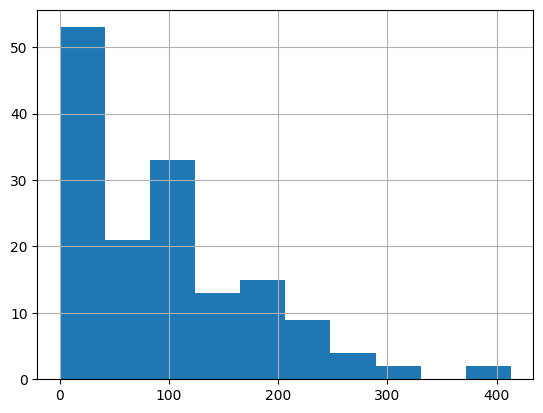

count    152.000000
mean      98.723684
std       82.133972
min        0.000000
25%       28.000000
50%       83.500000
75%      136.250000
max      413.000000
Name: n_j, dtype: float64


In [16]:
print('[INFO] Number of parcels sampled per bin')
Neyman_alloc['n_j'].hist()
plt.show()

print(Neyman_alloc['n_j'].describe())

In [17]:
Neyman_alloc.sort_values('n_j')

,Bin,N_j,S_j,weight,n_j
151,IS_MISSING-3.0,4,0.084819,0.000017,0.0
150,IS_MISSING-1.0,23,0.084819,0.000097,1.0
133,IS_49-2.0,95,0.084819,0.000399,6.0
130,IS_48-2.0,101,0.084819,0.000425,6.0
13,IS_12-2.0,144,0.084819,0.000605,9.0
...,...,...,...,...,...
63,IS_28-1.0,2358,0.162192,0.018956,284.0
6,IS_10-1.0,2592,0.152477,0.019589,294.0
99,IS_39-1.0,4847,0.084819,0.020377,306.0
33,IS_19-1.0,3133,0.162898,0.025296,380.0


### 3.2 Sample per Neyman allocation


In [18]:
# Sample n_j samples for each bin
np.random.seed(42)

iteration3_parcels = []
for final_bin in Neyman_alloc['Bin'].unique():
    n_j = Neyman_alloc.loc[Neyman_alloc['Bin'] == final_bin].iloc[0]['n_j']
    parcels_bin = neyman.loc[neyman['Bin'] == final_bin]['APN'].unique()
    try:
        sampled_parcels_bin = np.random.choice(parcels_bin, size=int(n_j), replace=False)
    except ValueError:
        sampled_parcels_bin = np.random.choice(parcels_bin, size=len(parcels_bin), replace=False)
        print('Sampling below Neyman alloc for bin {}: Num parcels: {}; nj: {}'.format(
            final_bin, len(parcels_bin), n_j))
    iteration3_parcels.extend(sampled_parcels_bin.tolist())
    
iteration3 = neyman.copy()
iteration3 = iteration3.loc[iteration3['APN'].isin(iteration3_parcels)]
print('[INFO] Sampling {} parcels'.format(len(iteration3)))

iteration3[['APN', 'GEOID', 'strata_inc', 'confidence', 'Bin']].to_csv(
    os.path.join(OUTPUT_FP, '..', 'CloudFactory', 'Iteration3', 'complete_sampled_APNs.csv'), index=False)

[INFO] Sampling 15006 parcels


In [106]:
# Remove parcels that have been annotated in B1 or B2
iter1 = pd.read_csv(
    os.path.join(OUTPUT_FP, '..', 'CloudFactory', 'Iteration1', 'sampled_APNs.csv'), dtype={'APN': str})
iter2 = pd.read_csv(
    os.path.join(OUTPUT_FP, '..', 'CloudFactory', 'Iteration2', 'sampled_APNs.csv'), dtype={'APN': str})

b1_b2_parcels = [apn for apn in iteration3['APN'] if apn in list(
    iter1['APN'].unique()) + list(iter2['APN'].unique())]
iteration3 = iteration3.loc[~iteration3['APN'].isin(
    list(iter1['APN'].unique()) + list(iter2['APN'].unique()))]
print('[INFO] Number of parcels: {} after removing parcels in B1, B2'.format(len(iteration3)))

iteration3[['APN', 'GEOID', 'strata_inc', 'confidence', 'Bin']].to_csv(
    os.path.join(OUTPUT_FP, '..', 'CloudFactory', 'Iteration3', 'sampled_APNs.csv'), index=False)

[INFO] Number of parcels: 14208 after removing parcels in B1, B2


In [107]:
# Generate tile centroids
parcel_centroids3 = iteration3.copy()
parcel_centroids3['centroid'] = parcel_centroids3.geometry.centroid

parcel_centroids3[['APN', 'centroid']].to_csv(
    os.path.join(OUTPUT_FP, '..', 'CloudFactory', 'Iteration3', 'parcel_centroids.csv'), index=False)

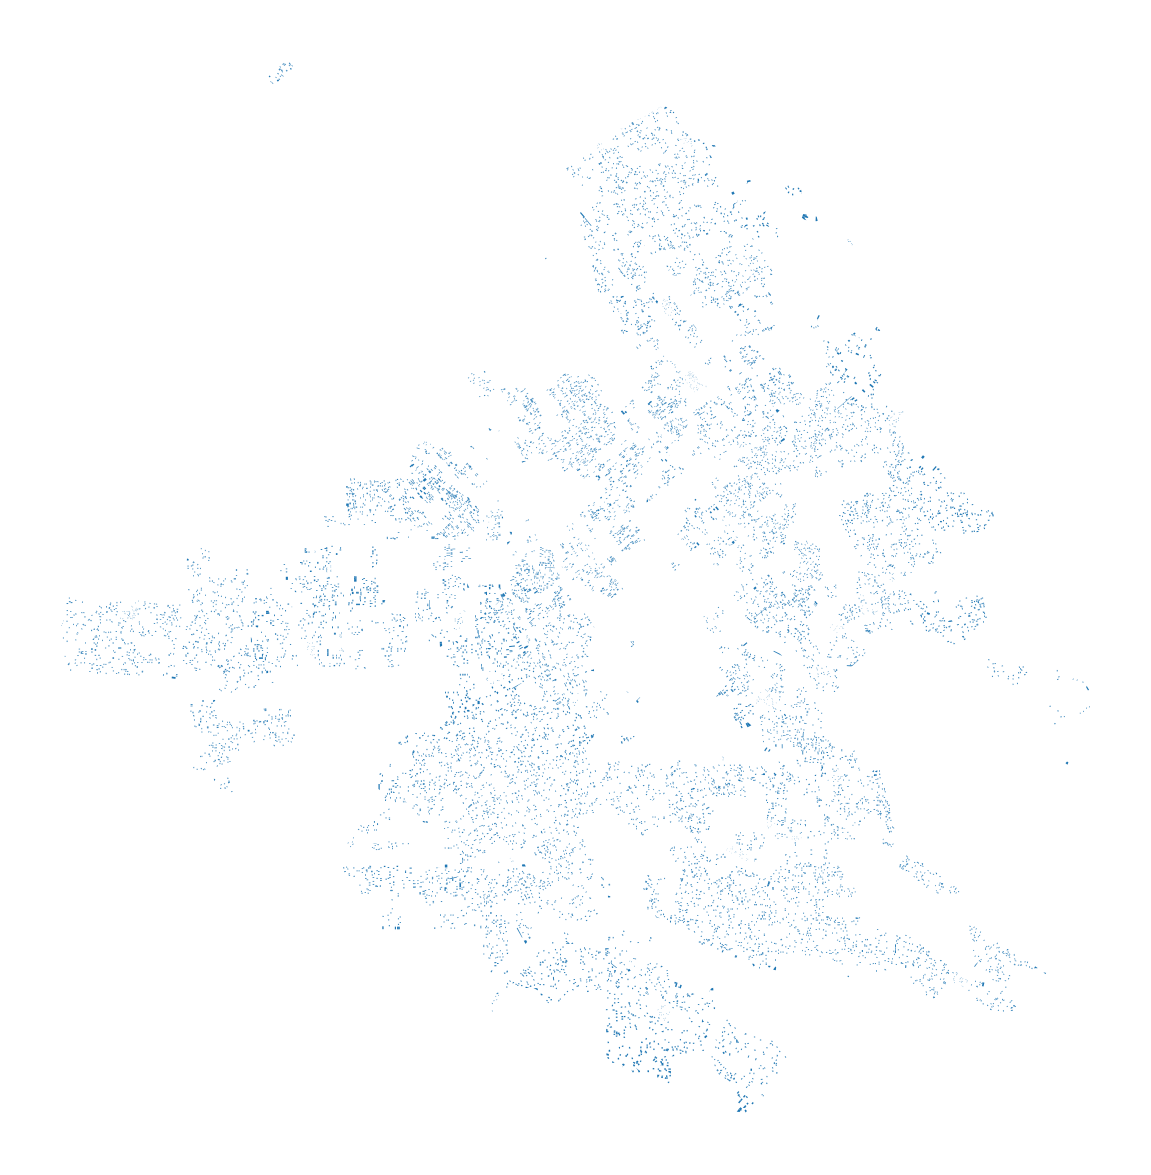

In [108]:
fig, ax = plt.subplots(figsize=(15, 15))
iteration3.plot(ax=ax)
ax.axis('off')
plt.show()

In [109]:
iteration3 = pd.read_csv(
    os.path.join(OUTPUT_FP, '..', 'CloudFactory', 'Iteration3', 'sampled_APNs.csv'), dtype={'APN': str})
parcel_centroids3 = pd.read_csv(
    os.path.join(OUTPUT_FP, '..', 'CloudFactory', 'Iteration3', 'parcel_centroids.csv'), dtype={'APN': str})